In [1]:
# Install required libraries
!pip install transformers datasets sentence-transformers rouge-score --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.1 MB/s eta 0:00:00


In [2]:
# Import required libraries
import random
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from transformers import DataCollatorForSeq2Seq
from datasets import Dataset
import torch
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Small dataset
documents = [
    [
        "The stock market crashed on Monday.",
        "Investors were worried about inflation.",
        "Tech stocks led the losses.",
        "Analysts predict a slow recovery.",
        "Some investors see buying opportunities."
    ],
    [
        "The hurricane caused severe flooding.",
        "Thousands were evacuated from coastal areas.",
        "Emergency crews rescued stranded residents.",
        "Roads and bridges were damaged.",
        "Authorities declared a state of emergency."
    ],
]


In [7]:
# Load sentence encoder (for centroid calculation)
sent_encoder = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Construct training examples: (input = 3 sentences) → (target = most centroid-like sentence)
examples = []
for doc in documents:
    for _ in range(2):
        group = random.sample(doc, 3)
        vectors = sent_encoder.encode(group)
        centroid = np.mean(vectors, axis=0)
        sims = [np.dot(centroid, sent_encoder.encode([s])[0]) for s in doc]
        target = doc[np.argmax(sims)]
        examples.append({"input": " ".join(group), "target": target})

In [9]:
# Load tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [10]:
# Tokenize dataset
def preprocess(ex):
    model_inputs = tokenizer(ex["input"], max_length=256, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(ex["target"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

ds = Dataset.from_list(examples)
tokenized = ds.map(preprocess)

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    logging_dir="./logs",
    logging_steps=5,
    save_strategy="no",
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Start training
trainer.train()

Step,Training Loss
5,12.608100


TrainOutput(global_step=6, training_loss=12.399505138397217, metrics={'train_runtime': 46.1656, 'train_samples_per_second': 0.26, 'train_steps_per_second': 0.13, 'total_flos': 1829209374720.0, 'train_loss': 12.399505138397217, 'epoch': 3.0})

In [12]:
# generating from one example
test_input = examples[0]["input"]
inputs = tokenizer(test_input, return_tensors="pt", max_length=256, truncation=True)
summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=64)
print("INPUT:", test_input)
print("GENERATED OUTPUT:", tokenizer.decode(summary_ids[0], skip_special_tokens=True))
print("EXPECTED TARGET:", examples[0]["target"])

INPUT: Analysts predict a slow recovery. Tech stocks led the losses. The stock market crashed on Monday.
GENERATED OUTPUT: Analysts predict a slow recovery. Tech stocks led the losses.The stock market crashed on Monday. The stock market went down on Tuesday. The tech stocks crashed on Wednesday.The STOCK STOCK MARKETS STOCKS STOCK CHALLOCK CHANGED CHANGS
EXPECTED TARGET: Tech stocks led the losses.


In [14]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

# Load a pretrained sentence embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings
embeddings = embedder.encode(all_sentences)


In [15]:
from transformers import BartTokenizer, BartModel
import torch

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
bart_model = BartModel.from_pretrained("facebook/bart-large")

# Get CLS-style embeddings (mean-pooled last hidden state)
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bart_model(**inputs)
        # Mean pooling
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

embeddings = [get_embedding(sent) for sent in all_sentences]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


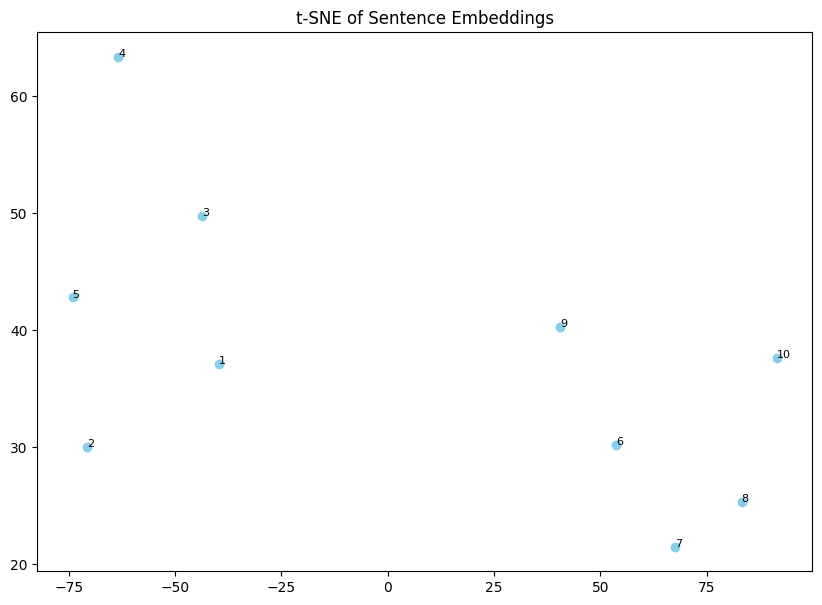

In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load sentence embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Flatten the documents
all_sentences = [sent for doc in documents for sent in doc]

# Get embeddings
embeddings = embedder.encode(all_sentences)

# Use t-SNE with low perplexity (e.g., 3)
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
reduced = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1], c='skyblue')
for i, sent in enumerate(all_sentences):
    plt.annotate(f"{i+1}", (reduced[i, 0], reduced[i, 1]), fontsize=8)
plt.title("t-SNE of Sentence Embeddings")
plt.show()


In [23]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load model and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Generate summaries for each document
generated_summaries = []
for doc in documents:
    input_text = " ".join(doc)
    inputs = tokenizer([input_text], max_length=1024, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=100, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summaries.append(summary)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [24]:
from rouge_score import rouge_scorer

def compute_rouge(reference, prediction):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, prediction)
    return scores

# Compute and print ROUGE scores
for i, pred in enumerate(generated_summaries):
    ref = " ".join(documents[i])
    print(f"\nDocument {i+1} ROUGE Scores:")
    print(compute_rouge(ref, pred))



Document 1 ROUGE Scores:
{'rouge1': Score(precision=0.7, recall=0.8076923076923077, fmeasure=0.75), 'rouge2': Score(precision=0.6551724137931034, recall=0.76, fmeasure=0.7037037037037037), 'rougeL': Score(precision=0.7, recall=0.8076923076923077, fmeasure=0.75)}

Document 2 ROUGE Scores:
{'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=0.9230769230769231, recall=0.9230769230769231, fmeasure=0.9230769230769231), 'rougeL': Score(precision=0.7777777777777778, recall=0.7777777777777778, fmeasure=0.7777777777777778)}


In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the SentenceTransformer model (if not already)
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Cosine similarity between centroid and summary
for i, doc in enumerate(documents):
    # Get sentence embeddings for all sentences in the document
    doc_embeddings = embedder.encode(doc)

    # Compute centroid embedding
    centroid_embedding = np.mean(doc_embeddings, axis=0)

    # Encode the summary
    summary_embedding = embedder.encode([generated_summaries[i]])[0]

    # Compute cosine similarity
    similarity = cosine_similarity([centroid_embedding], [summary_embedding])[0][0]
    print(f"Document {i+1} centroid-summary similarity: {similarity:.4f}")


Document 1 centroid-summary similarity: 0.7863
Document 2 centroid-summary similarity: 0.8949


In [28]:

for i, (doc, summary) in enumerate(zip(documents, generated_summaries)):
    print(f"\n--- Document {i+1} ---")
    print("Original:\n", " ".join(doc))
    print("Summary:\n", summary)


--- Document 1 ---
Original:
 The stock market crashed on Monday. Investors were worried about inflation. Tech stocks led the losses. Analysts predict a slow recovery. Some investors see buying opportunities.
Summary:
 The stock market crashed on Monday. Tech stocks led the losses. Analysts predict a slow recovery. Some investors see buying opportunities. The market is down more than 2% this week.

--- Document 2 ---
Original:
 The hurricane caused severe flooding. Thousands were evacuated from coastal areas. Emergency crews rescued stranded residents. Roads and bridges were damaged. Authorities declared a state of emergency.
Summary:
 The hurricane caused severe flooding. Authorities declared a state of emergency. Thousands were evacuated from coastal areas. Emergency crews rescued stranded residents. Roads and bridges were damaged.
